# Q2: Guided backpropagation

#### README:
- Set path to imagenet folder: --img_path './imgnet500'
- Choose model to use: --choose_model [vgg16, vgg16_bn]
- Choose number of images to display: --display_num = 5
- Run guidedbp(img_path, choose_model, display_num)

In [1]:
# import libraries
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
import os
from torchvision import models
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# dataset
class dataset_imagenetvalpart(Dataset):
  def __init__(self, root_dir, maxnum, skip=0, transform=None):

    """
    Args:

        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """

    self.root_dir = root_dir
    self.transform = transforms.Compose([transforms.Resize(224),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])    
    self.imgfilenames=[]
    self.ending=".JPEG"
    
    allfiles=[]
    for root, dirs, files in os.walk(self.root_dir):
      allfiles.extend(files)
    allfiles = sorted(allfiles)

    for ct,name in enumerate(allfiles):
      if ct < skip:
        continue
        
      nm=os.path.join(root, name)
      if (maxnum >0) and ct>= (maxnum + skip):
        break
      self.imgfilenames.append(nm)

  def __len__(self):
      return len(self.imgfilenames)

  def __getitem__(self, idx):
    image = PIL.Image.open(self.imgfilenames[idx]).convert('RGB')

    if self.transform:
      image = self.transform(image)

    sample = {'image': image, 'filename': self.imgfilenames[idx]}

    return sample

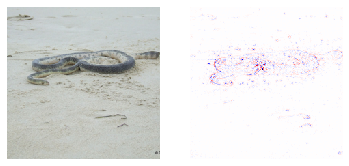

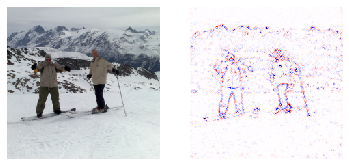

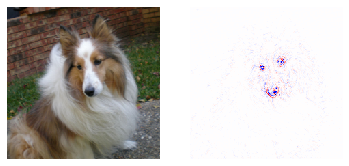

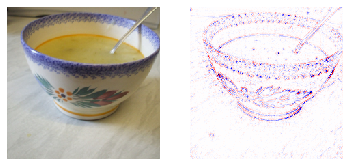

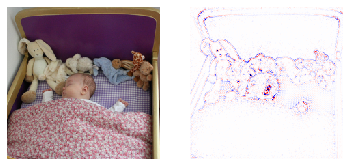

In [3]:
# Guided BP
class CustomRelu(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        grad_input[grad_input < 0] = 0
        return grad_input

class MyRelu(nn.Module):
    def __init__(self):
        super(MyRelu, self).__init__()

    def forward(self, input):
        return CustomRelu.apply(input)

def setbyname(model, name, value):
    def iteratset(obj, components, value):
        if not hasattr(obj, components[0]):
            return False
        elif len(components) == 1:
            setattr(obj, components[0], value)
            return True
        else:
            nextobj = getattr(obj, components[0])
            return iteratset(nextobj, components[1:], value)

    components = name.split('.')
    success = iteratset(model, components, value)
    return success


def imshow2(hm, imgtensor, q=100):
    def invert_normalize(ten, mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]):  
        s=torch.tensor(np.asarray(std,dtype=np.float32)).unsqueeze(1).unsqueeze(2)
        m=torch.tensor(np.asarray(mean,dtype=np.float32)).unsqueeze(1).unsqueeze(2)

        res=ten*s+m
        return res
    
    def showimgfromtensor(inpdata):
      ts=invert_normalize(inpdata)
      a=ts.data.squeeze(0).numpy()
      saveimg=(a*255.0).astype(np.uint8)
    
    fig, axs = plt.subplots(1, 2)

    hm = hm.squeeze().sum(dim=0).numpy()

    clim = np.percentile(np.abs(hm), q)
    hm = hm / clim
    axs[1].imshow(hm, cmap="seismic", clim=(-1, 1))
    axs[1].axis('off')

    ts=invert_normalize(imgtensor.squeeze(0))
    a=ts.data.numpy().transpose((1, 2, 0))
    axs[0].imshow(a)
    axs[0].axis('off')

    plt.show()
    
def guidedbp(img_path, choose_model, display_num = 5):
    # Create dataset    
    dataset = dataset_imagenetvalpart(img_path, 500)     

    if choose_model == 'vgg16':
        model = models.vgg16(pretrained=True)
    if choose_model == 'vgg16_bn':
        model = models.vgg16_bn(pretrained=True)

    model.eval()   
    
    for n, m in model.named_modules():
        if isinstance(m, torch.nn.ReLU):
            myrelu = MyRelu()
            setbyname(model, n, myrelu)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    count = 0
    for data in dataset:
        image = data['image']
        image = image.to(device).unsqueeze(0)   
        image.requires_grad = True

        model.to(device)
        model.zero_grad()
        outputs = model(image)
        topclass = torch.max(outputs, 1)[1].to(device)
        loss = criterion(outputs, topclass)
        loss.backward()

        grad = image.grad.data.to('cpu')
        image = image.to('cpu')
        imshow2(grad, image)

        count += 1
        if count == display_num:
            break

img_path = './imgnet500'
choose_model = 'vgg16'
display_num = 5
guidedbp(img_path, choose_model)